# Vision Transformer for Fashion-MNIST classification problem
Code adapted from https://github.com/gupta-abhay/pytorch-vit

__Train a base Visual Transformer for Fashion-MNIST using 150 Epochs__

In [33]:
import PIL
import time
import torch
import torchvision
import torch.nn.functional as F
from einops import rearrange
from torch import nn

device = 'cuda' if torch.cuda.is_available() else 'cpu'

class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(x, **kwargs) + x 

class LayerNormalize(nn.Module):
    def __init__(self, dim, fn): 
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

class MLP_Block(nn.Module):
    def __init__(self, dim, hidden_dim, dropout = 0.1):
        super().__init__()
        self.nn1 = nn.Linear(dim, hidden_dim)
        torch.nn.init.xavier_uniform_(self.nn1.weight)
        torch.nn.init.normal_(self.nn1.bias, std = 1e-6)
        self.af1 = nn.GELU()
        self.do1 = nn.Dropout(dropout)
        self.nn2 = nn.Linear(hidden_dim, dim)
        torch.nn.init.xavier_uniform_(self.nn2.weight)
        torch.nn.init.normal_(self.nn2.bias, std= 1e-6)
        self.do2 = nn.Dropout(dropout)
    def forward(self, x): 
        x = self.nn1(x)
        x = self.af1(x)
        x = self.do1(x)
        x = self.nn2(x)
        x = self.do2(x)
        return x 

class Attention(nn.Module):
    def __init__(self, dim, heads = 8, dropout = 0.1):
        super().__init__()
        self.heads = heads
        self.scale = dim ** -0.5

        self.to_qkv = nn.Linear(dim, dim * 3, bias = True)
        torch.nn.init.xavier_uniform_(self.to_qkv.weight)
        torch.nn.init.zeros_(self.to_qkv.bias)

        self.nn1 = nn.Linear(dim, dim)
        torch.nn.init.xavier_uniform_(self.nn1.weight)
        torch.nn.init.zeros_(self.nn1.bias)        
        self.do1 = nn.Dropout(dropout)

    def forward(self, x, mask = None):
        b, n, _, h = *x.shape, self.heads
        qkv = self.to_qkv(x)
        q, k, v = rearrange(qkv, 'b n (qkv h d) -> qkv b h n d', qkv = 3, h = h)

        dots = torch.einsum('bhid,bhjd->bhij', q, k) * self.scale

        if mask is not None:
            mask = F.pad(mask.flatten(1), (1, 0), value = True)
            assert mask.shape[-1] == dots.shape[-1], 'mask has incorrect dimensions'
            mask = mask[:, None, :] * mask[:, :, None]
            dots.masked_fill_(~mask, float('-inf'))
            del mask

        attn = dots.softmax(dim=-1) #follow the softmax,q,d,v equation in the paper

        out = torch.einsum('bhij,bhjd->bhid', attn, v) #product of v times whatever inside softmax
        out = rearrange(out, 'b h n d -> b n (h d)') #concat heads into one matrix, ready for next encoder block
        out =  self.nn1(out)
        out = self.do1(out)
        return out

class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, mlp_dim, dropout):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                Residual(LayerNormalize(dim, Attention(dim, heads = heads, dropout = dropout))),
                Residual(LayerNormalize(dim, MLP_Block(dim, mlp_dim, dropout = dropout)))
            ]))
    def forward(self, x, mask= None):
        for attention, mlp in self.layers:
                x = attention(x, mask = mask)
                x = mlp(x)
        return x

class ImageTransformer(nn.Module):
    def __init__(self, *, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, channels = 3, dropout = 0.1, emb_dropout = 0.1):
        super().__init__()
        assert image_size % patch_size == 0, 'image dimensions must be divisible by the patch size'
        num_patches = (image_size // patch_size) ** 2  # e.g. (32/4)**2= 64
        patch_dim = channels * patch_size ** 2  # e.g. 3*8**2 = 64*3

        self.patch_size = patch_size
        self.pos_embedding = nn.Parameter(torch.empty(1, (num_patches + 1), dim))
        torch.nn.init.normal_(self.pos_embedding, std = .02) # initialized based on the paper
        self.patch_conv= nn.Conv2d(channels,dim, patch_size, stride = patch_size) #eqivalent to x matmul E, E= embedd matrix, this is the linear patch projection
        
        #self.E = nn.Parameter(nn.init.normal_(torch.empty(BATCH_SIZE_TRAIN,patch_dim,dim)),requires_grad = True)
        
        self.cls_token = nn.Parameter(torch.zeros(1, 1, dim)) #initialized based on the paper
        self.dropout = nn.Dropout(emb_dropout)

        self.transformer = Transformer(dim, depth, heads, mlp_dim, dropout)

        self.to_cls_token = nn.Identity()

        self.nn1 = nn.Linear(dim, num_classes)  # if finetuning, just use a linear layer without further hidden layers (paper)
        torch.nn.init.xavier_uniform_(self.nn1.weight)
        torch.nn.init.normal_(self.nn1.bias, std = 1e-6)
        # self.af1 = nn.GELU() # use additinal hidden layers only when training on large datasets
        # self.do1 = nn.Dropout(dropout)
        # self.nn2 = nn.Linear(mlp_dim, num_classes)
        # torch.nn.init.xavier_uniform_(self.nn2.weight)
        # torch.nn.init.normal_(self.nn2.bias)
        # self.do2 = nn.Dropout(dropout)

    def forward(self, img, mask = None):
        p = self.patch_size

        x = self.patch_conv(img) # each of 64 vecotrs is linearly transformed with a FFN equiv to E matmul
        #x = torch.matmul(x, self.E)
        x = rearrange(x, 'b c h w -> b (h w) c') # 64 vectors in rows representing 64 patches, each 64*3 long

        cls_tokens = self.cls_token.expand(img.shape[0], -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding
        x = self.dropout(x)

        x = self.transformer(x, mask) #main game

        x = self.to_cls_token(x[:, 0])
        
        x = self.nn1(x)
        # x = self.af1(x)
        # x = self.do1(x)
        # x = self.nn2(x)
        # x = self.do2(x)
        
        return x

In [34]:
def train(model, optimizer, data_loader, loss_history, device=device):
    total_samples = len(data_loader.dataset)
    model.to(device)
    model.train()

    for i, (data, target) in enumerate(data_loader):
        data, target = data.to(device),target.to(device)
        optimizer.zero_grad()
        output = F.log_softmax(model(data), dim=1)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()

        if i % 100 == 0:
            print('[' +  '{:5}'.format(i * len(data)) + '/' + '{:5}'.format(total_samples) +
                  ' (' + '{:3.0f}'.format(100 * i / len(data_loader)) + '%)]  Loss: ' +
                  '{:6.4f}'.format(loss.item()))
            loss_history.append(loss.item())
            
def evaluate(model, data_loader, loss_history, device=device):
    model.to(device)
    model.eval()
    
    total_samples = len(data_loader.dataset)
    correct_samples = 0
    total_loss = 0

    with torch.no_grad():
        for data, target in data_loader:
            data, target= data.to(device),target.to(device)
            
            output = F.log_softmax(model(data), dim=1)
            loss = F.nll_loss(output, target, reduction='sum')
            _, pred = torch.max(output, dim=1)
            
            total_loss += loss.item()
            correct_samples += pred.eq(target).sum()

    avg_loss = total_loss / total_samples
    loss_history.append(avg_loss)
    print('\nAverage test loss: ' + '{:.4f}'.format(avg_loss) +
          '  Accuracy:' + '{:5}'.format(correct_samples) + '/' +
          '{:5}'.format(total_samples) + ' (' +
          '{:4.2f}'.format(100.0 * correct_samples / total_samples) + '%)\n')
    return avg_loss

In [35]:
BATCH_SIZE_TRAIN = 100
BATCH_SIZE_TEST = 100

import torchvision.transforms as transforms
from torchvision.datasets import FashionMNIST
import torch.optim as optim
import torch.nn.functional as F
import torch
import os

# Define transforms
transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Resize images to 32x32 to match the model
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load Fashion MNIST dataset
train_dataset = FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = FashionMNIST(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE_TRAIN, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE_TEST, shuffle=False)

N_EPOCHS = 150

# Assuming model and other training components (optimizer, train, and evaluate functions) are defined as per your provided code
# Adjust model instantiation for 1 channel input and appropriate image size
model = ImageTransformer(image_size=32, patch_size=4, num_classes=10, channels=1,  # Adjust for 1 channel
                         dim=64, depth=6, heads=8, mlp_dim=128)

optimizer = optim.Adam(model.parameters(), lr=0.003)

# Early stopping parameters
#patience = 20  # Number of epochs to wait after last time validation loss improved.
best_loss = float('inf')
#patience_counter = 0

# Train and evaluate the model
train_loss_history, test_loss_history = [], []
best_model_state = None  # To save the best model state
PATH = "models/fashion_mnist_base_transformer.pt" 

if os.path.exists(PATH):
    print("Loading existing model weights.")
    model.load_state_dict(torch.load(PATH))
    
else:
    print("Training new model.")
    for epoch in range(1, N_EPOCHS + 1):
        print('Epoch:', epoch)
        start_time = time.time()
        train(model, optimizer, train_loader, train_loss_history)
        print('Execution time:', '{:5.2f}'.format(time.time() - start_time), 'seconds')
        val_loss = evaluate(model, test_loader, test_loss_history)
    
        # Check if validation loss improved
        if val_loss < best_loss:
            best_loss = val_loss
            #patience_counter = 0  # Reset counter
            best_model_state = model.state_dict()  # Save the best model state
            torch.save(best_model_state, PATH)
        # else:
            #patience_counter += 1
            
        # Early stopping check
        # if patience_counter >= patience:
        #     print("Early stopping triggered at epoch:", epoch)
        #     break
    
    
    # After the loop, save the best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)  # Load the best model state
        torch.save(model.state_dict(), PATH)  # Save the best model
    else:
        print("No improvement was observed; hence, the model at the last epoch is considered the best.")


Loading existing model weights.


## Use the trained model to predict some test data 

In [36]:
import random 

random.seed(42)

classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

test_samples = []
test_labels = []
for sample, label in random.sample(list(test_dataset), k=9):
    test_samples.append(sample)
    test_labels.append(label)

# View the first test sample shape and label
print(f"Test sample image shape: {test_samples[0].shape}\nTest sample label: {test_labels[0]} ({classes[test_labels[0]]})")

Test sample image shape: torch.Size([1, 32, 32])
Test sample label: 5 (Sandal)


In [37]:
def make_predictions(model: torch.nn.Module, data: list, device: torch.device = device):
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            sample = torch.unsqueeze(sample, dim=0) # Add an extra dimension 

            pred_logit = model(sample)

            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 1, so can perform on dim=0)

            pred_probs.append(pred_prob.cpu())
            
    return torch.stack(pred_probs)


In [38]:
model.load_state_dict(torch.load(PATH))
pred_probs= make_predictions(model=model, 
                             data=test_samples)
pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([5, 1, 7, 4, 3, 0, 4, 7, 1])

In [39]:
test_labels, pred_classes

([5, 1, 7, 4, 3, 0, 4, 7, 1], tensor([5, 1, 7, 4, 3, 0, 4, 7, 1]))

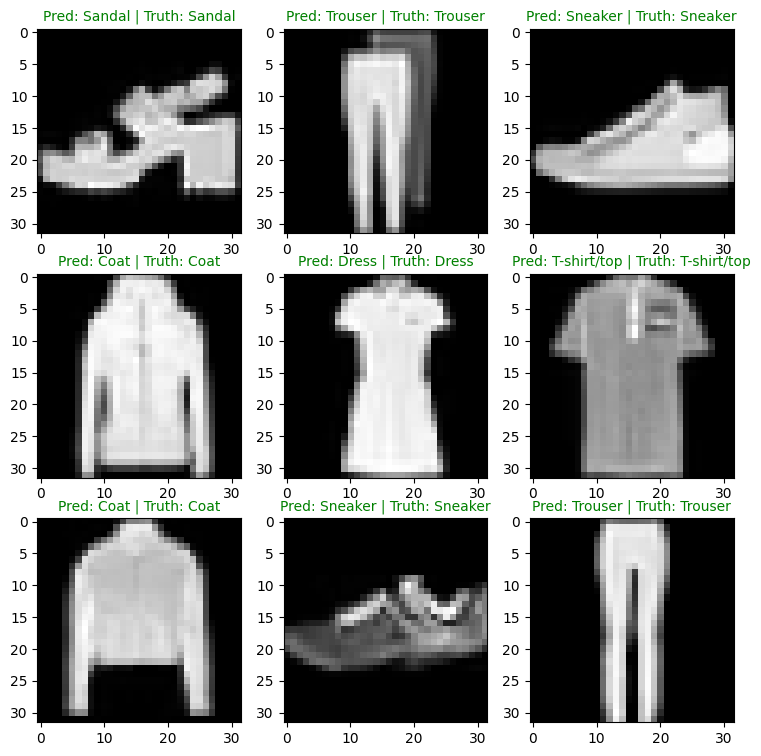

In [40]:
import matplotlib.pyplot as plt

#visualize test
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
  plt.subplot(nrows, ncols, i+1)

  plt.imshow(sample.squeeze(), cmap="gray")

  pred_label = classes[pred_classes[i]]

  truth_label = classes[test_labels[i]] 

  title_text = f"Pred: {pred_label} | Truth: {truth_label}"
  
  if pred_label == truth_label:
      plt.title(title_text, fontsize=10, c="g") # green text if correct
  else:
      plt.title(title_text, fontsize=10, c="r") # red text if wrong